The Stock Market dataset from Kaggle, which includes daily stock market prices for the NASDAQ, NYSE, and S&P500, is used in this notebook to investigate deep learning methods. **Creating a model that could predict the closing price for the upcoming month was the aim.**

Data wrangling, feature engineering, dividing the data into test, validation, and training sets, and getting ready for deep learning modeling were all part of the workflow.


 We then trained a variety of models, such as CNN, combination models, autoregressive LSTM, baseline, linear, and deep neural networks. Every model sought to increase the precision of our projections. 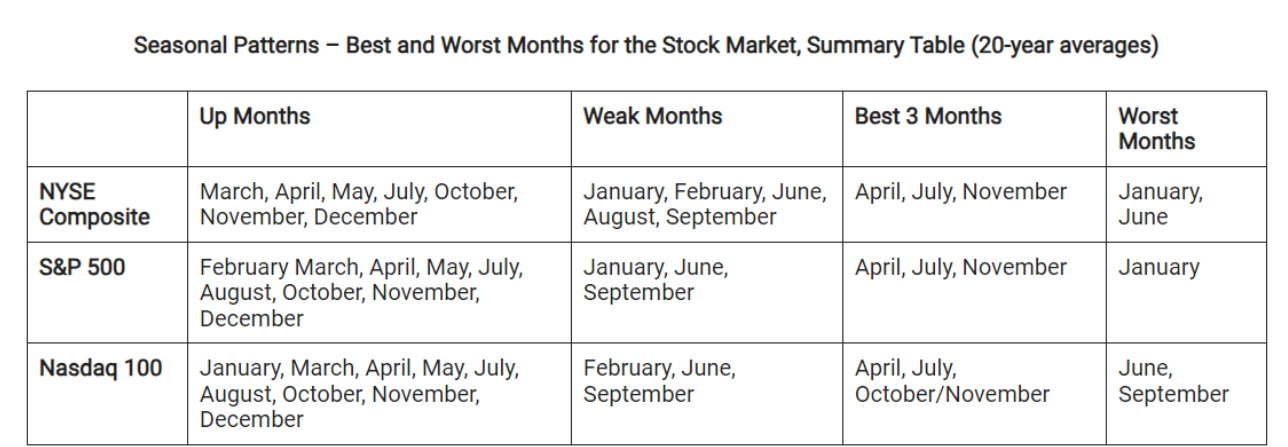

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

import datetime

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [5]:
plt.rcParams['figure.figsize'] = (10, 4)

Whenever numpy and TensorFlow are used, It's prefered to set a random seed to ensure constant results when training models. Recall that the initialization of deep learning models is random, so training the same model twice in a row might result in slightly different performance. Thus, to ensure reproducibility, we set a random seed. If we do not set a seed, results might vary each time.


In [6]:
tf.random.set_seed(42)
np.random.seed(42)

**Loading Datas**

In [7]:
df=pd.read_csv("AAL.csv")

In [8]:
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,27-09-2005,19.100000,21.049999,961200,21.400000,19.299999,18.194910
1,28-09-2005,19.200001,19.299999,5747900,20.530001,20.500000,19.326204
2,29-09-2005,20.100000,20.400000,1078200,20.580000,20.209999,19.052805
3,30-09-2005,20.180000,20.260000,3123300,21.049999,21.010000,19.807001
4,03-10-2005,20.900000,20.900000,1057900,21.750000,21.500000,20.268940


#### Data Wrangling and Processing


In [9]:
# Let's check start-date of data
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,27-09-2005,19.100000,21.049999,961200,21.400000,19.299999,18.194910
1,28-09-2005,19.200001,19.299999,5747900,20.530001,20.500000,19.326204
2,29-09-2005,20.100000,20.400000,1078200,20.580000,20.209999,19.052805
3,30-09-2005,20.180000,20.260000,3123300,21.049999,21.010000,19.807001
4,03-10-2005,20.900000,20.900000,1057900,21.750000,21.500000,20.268940


In [10]:
#let's check end date of data
df.tail()

,Date,Low,Open,Volume,High,Close,Adjusted Close
4328,06-12-2022,14.00,14.14,20781500,14.34,14.330,14.330
4329,07-12-2022,13.53,14.24,28161400,14.24,13.550,13.550
4330,08-12-2022,13.38,13.65,25300900,13.80,13.600,13.600
4331,09-12-2022,13.42,13.52,18489800,13.66,13.530,13.530
4332,12-12-2022,13.45,13.49,8048550,13.93,13.915,13.915


This shows that our data starts on September 27, 2005, and ends on December 12, 2022, and that the data was collected at every day.

In [11]:
#Let us check the shape of the data
df.shape

(4333, 7)

In [13]:
#Let's check the missing data
df.isna().sum()

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

In [15]:
#Let's check categorical values
df.dtypes

Date               object
Low               float64
Open              float64
Volume              int64
High              float64
Close             float64
Adjusted Close    float64
dtype: object

In [16]:
# Convert 'Date' column to datetime data type
df['Date'] = pd.to_datetime(df['Date'])

#### **Data Resampling**
The next step is to check if data sampled every day is appropriate for modeling. It is possible that data sampled every day is too noisy to build a performant predictive model.

First, Let's check how many working days per each month

In [17]:
# Group the data by month and count the number of unique days per month
days_per_month = df.groupby(df['Date'].dt.to_period('M'))['Date'].nunique()

#convert series to dataframe
days_per_month = pd.DataFrame(days_per_month)
days_per_month.head(20)

,Date
Date,
2005-01,2
2005-02,2
2005-03,2
2005-04,2
2005-05,2
2005-06,2
2005-07,3
2005-08,2
2005-09,6


Year 2005 seems to have less working days than other years , let's drop it.

In [18]:
# Drop rows where the year is 2005
df = df[df['Date'].dt.year != 2005]

#  resetting the DataFrame index
df.reset_index(inplace = True, drop = True)

df.head(5)

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,2006-03-01,36.849998,37.200001,1013200,38.279999,37.450001,35.305672
1,2006-04-01,37.700001,37.700001,1928400,40.599998,39.200001,36.955467
2,2006-05-01,38.910000,39.180000,317900,39.709999,39.709999,37.436268
3,2006-06-01,38.139999,39.709999,349200,39.709999,39.000000,36.766914
4,2006-09-01,38.500000,38.799999,220800,38.880001,38.610001,36.399242


we need to make sure that our data does not show any large oscillations or flat sequences occurring at every day, which may be difficult to forecast using a deep learning model, since it seems to move at random.

To check this, we’ll simply plot our target to see what it looks like.

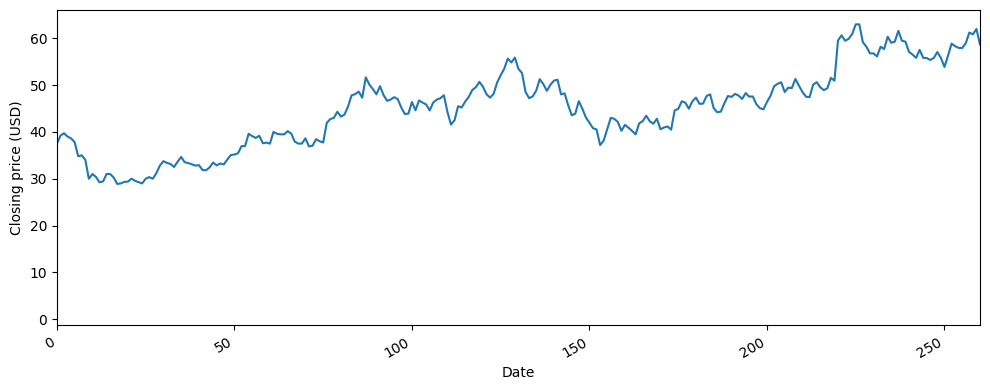

In [19]:
# Plot first year (260 day) of target

fig, ax = plt.subplots(figsize=(10,4))

ax.plot(df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

ax.set_xlim(0, 260)

fig.autofmt_xdate()
plt.tight_layout()

#### Figure:
 Close price sampled every day for one year. We may have a smooth pattern. This is ready to be forecast with a deep learning model. Thus, we do not need to resample our data.

#### Save Data :

With the data wrangling done, we can save our dataset as a CSV file so we have a clean version of our data. This will be our starting file for the next section.

In [20]:
df.to_csv('../clean_AAL.csv', header=True, index=False)

#### Feature Engineering ::
At this point, we have a clean dataset with no missing values and a smoothed pattern that will be easier to predict using deep learning techniques. Now we can read a clean version of the data and start working on the feature engineering.

In [21]:
df = pd.read_csv('../clean_AAL.csv')
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,2006-03-01,36.849998,37.200001,1013200,38.279999,37.450001,35.305672
1,2006-04-01,37.700001,37.700001,1928400,40.599998,39.200001,36.955467
2,2006-05-01,38.910000,39.180000,317900,39.709999,39.709999,37.436268
3,2006-06-01,38.139999,39.709999,349200,39.709999,39.000000,36.766914
4,2006-09-01,38.500000,38.799999,220800,38.880001,38.610001,36.399242


#### 1. Feature Selection
The first step in feature engineering is to display the basic statistics for each column. This is especially useful for detecting whether there are any variables that do not vary greatly. Such variables should be removed, since if they are almost constant over time, they are not predictive of our target.

In [22]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Low,4266.0,2.488723e+01,1.580789e+01,1.450000,1.053500e+01,2.133500e+01,3.914000e+01,6.200000e+01
Open,4266.0,2.538824e+01,1.600633e+01,1.810000,1.082250e+01,2.189000e+01,3.974500e+01,6.270000e+01
Volume,4266.0,1.458939e+07,2.207456e+07,191300.000000,4.749500e+06,7.557550e+06,1.352832e+07,4.286171e+08
High,4266.0,2.585412e+01,1.619366e+01,2.030000,1.111250e+01,2.224000e+01,4.029750e+01,6.327000e+01
Close,4266.0,2.535673e+01,1.600430e+01,1.760000,1.079250e+01,2.181500e+01,3.970500e+01,6.295000e+01
Adjusted Close,4266.0,2.439955e+01,1.533443e+01,1.659225,1.024113e+01,2.143500e+01,3.797598e+01,5.934557e+01


As seen in Tabl, A description of each column in our dataset. It seems that all variables vary much over time, so they are likely a good predictor for our target, and we do not need to drop any feature.


#### 2. Identifying the seasonal period:

- Stock market seasonal patterns are the directional tendencies of stock indices based on the time of the year. Certain times of the year tend to be more bullish (go up) for stocks, while other times during the year are more bearish (go down)

- Seasonality is essentially an average, based on history, of how the stock market tends to perform throughout the year. Averages are a guide, a tool, but don’t forecast with accuracy what will happen this year. That said, some investors and traders may use seasonal tendencies to build strategies or enhance existing ones.

- For example, if we know September tends to be a poor month for stocks, a trader who primarily takes long positions may opt to take this month off, or exit their positions quicker than usual if they start to decline during the month of September. A trader could buy stock index nasdaq (such as AAL) during seasonally strong months if they start rising. An investor may buy in and then sell out at certain times of the year (if feasible to do so with commissions). Buy-and-hold investors may wish to invest during seasonally weak months to take advantage of lower prices.

Before checking seasonality, let's plot mean close price per month and mean close price per year to detect any patterns.

In [24]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract the month and year from the 'Date' column
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year


# Calculate the mean close price per month
monthly_mean = df.groupby([ 'Month'])['Close'].mean().reset_index()

# Calculate the mean close price per year
yearly_mean = df.groupby([ 'Year'])['Close'].mean().reset_index()

In [25]:
monthly_mean

,Month,Close
0,1,26.306667
1,2,26.582044
2,3,25.933397
3,4,24.985652
4,5,25.469176
5,6,25.166778
6,7,24.916872
7,8,24.170026
8,9,24.357233
9,10,24.839057


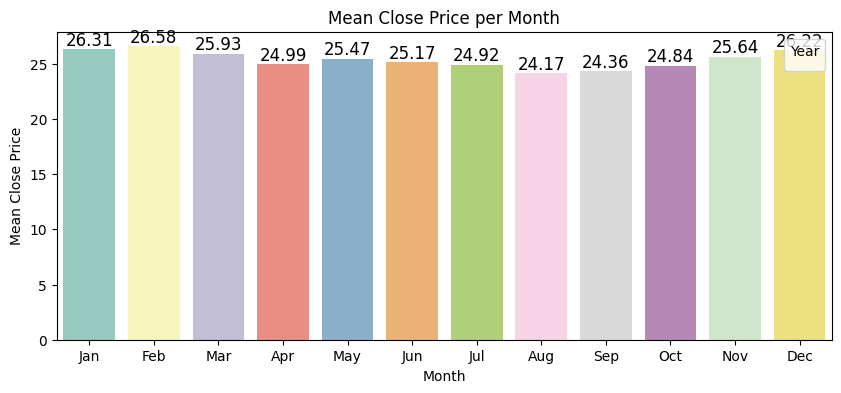

In [26]:
# Plot the mean close price per month using a Seaborn bar chart
ax =sns.barplot(data=monthly_mean, x='Month', y='Close',  palette='Set3')

plt.title('Mean Close Price per Month')
plt.xlabel('Month')
plt.ylabel('Mean Close Price')

plt.xticks(range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')


for bars in ax.containers:
     ax.bar_label(bars, fontsize=12, fmt='%.2f')
plt.show()

In [27]:
#Figure Mean Close Price almost similar for all months.
yearly_mean.head()

,Year,Close
0,2006,44.322390
1,2007,35.671952
2,2008,7.742134
3,2009,3.829643
4,2010,8.636667


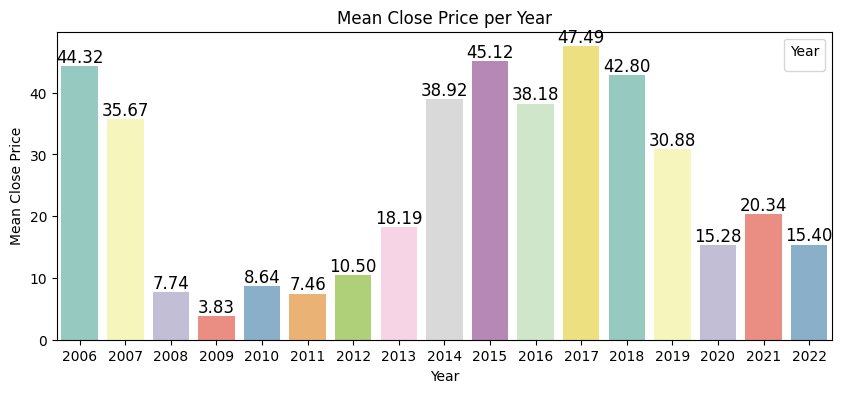

In [28]:
lst_year= yearly_mean['Year'].tolist()

# Plot the mean close price per month using a Seaborn bar chart
ax = sns.barplot(data=yearly_mean, x='Year', y='Close',  palette='Set3')

plt.title('Mean Close Price per Year')
plt.xlabel('Year')
plt.ylabel('Mean Close Price')

plt.xticks(range(0, len(lst_year)), labels=lst_year)
plt.legend(title='Year')

for bars in ax.containers:
     ax.bar_label(bars, fontsize=12, fmt='%.2f')

plt.show()

Figure : The highest mean close price for year 2017 was 47.49 USD, while the lowest was for year 2009 with 3.83 USD, Let's use a Lineplot for more illustrations of both (2009,2017) years..

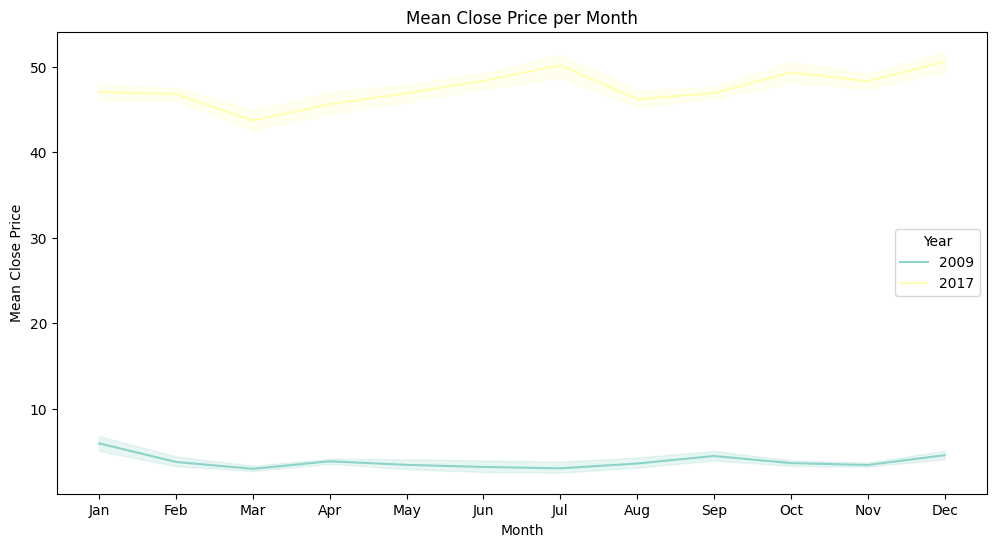

In [29]:
# Plot the mean close price per month using a Seaborn bar chart
plt.figure(figsize=(12, 6))

filtered_df = df[df['Year'].isin([2009,2017])]
sns.lineplot(data=filtered_df, x='Month', y='Close', hue='Year', palette='Set3')

plt.title('Mean Close Price per Month')

plt.xlabel('Month')
plt.ylabel('Mean Close Price')

plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.legend(title='Year')
plt.show()

#### Figure:

The bar chart showing the mean close price per years (2009,2017), with each year represented by a different color.

With our target being Closing price (USD), it is reasonable to assume that there may be some seasonality in our target.

We know that capture information from the previous seasonal cycle can help us forecast our time series. Therefore, it is important to determine ways to identify seasonality in time series. Usually, plotting the time series data is enough to observe periodic patterns.

We can plot our target to see if we can visually detect any seasonality.

#### Yearly Seasonality

yearly cyclic behavior refers to a repeating pattern or trend that occurs within each year, the absence of it indicates that there is no noticeable pattern or trend that repeats on an annual basis. This suggests that the stock market data does not exhibit consistent fluctuations or variations that occur predictably from one year to the next. There may be other factors or irregularities at play that overshadow any yearly cyclic behavior.

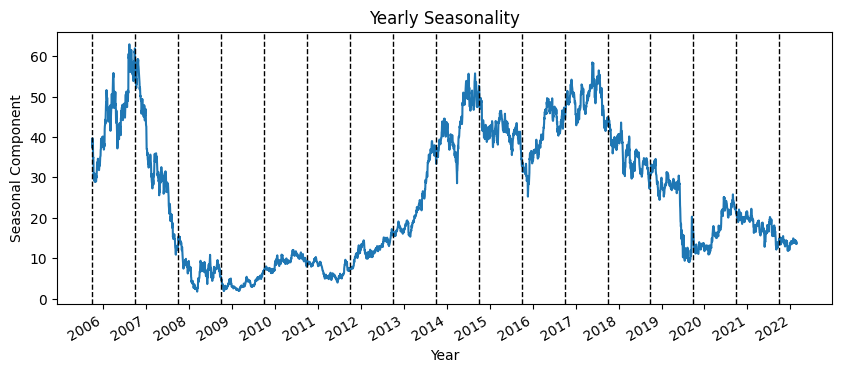

<Figure size 1000x500 with 0 Axes>

In [30]:
fig, ax = plt.subplots()

ax.plot(df['Close'])
for i in np.arange(0, len(df), 260):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)

plt.title('Yearly Seasonality')
plt.xlabel('Year')
plt.ylabel('Seasonal Component')

plt.xticks(np.arange(67, len(df), 260), np.arange(2006, 2023, 1))

plt.figure(figsize=(10, 5))

fig.autofmt_xdate()
plt.tight_layout()


Figure: Highlighting the seasonal pattern in the Yearly Close Price. The dashed vertical lines separate periods of 260 working days per year.

We can clearly see the yearly frequency does not show any cyclic behavior. Therefore, there is no yearly seasonality

Another way of identifying seasonal patterns in a time series is using time series decomposition,We can decompose the dataset for Stock Prices using the tsa.seasonal_decompose function from the statsmodels library

#### Monthly Seasonality

Monthly cyclic behavior refers to a **repeating pattern or trend that occurs within each month. It suggests that there are consistent fluctuations or variations in the stock market data that repeat on a monthly basis** . This could be due to various factors, such as economic events, market sentiment, or trading patterns that occur within specific months.

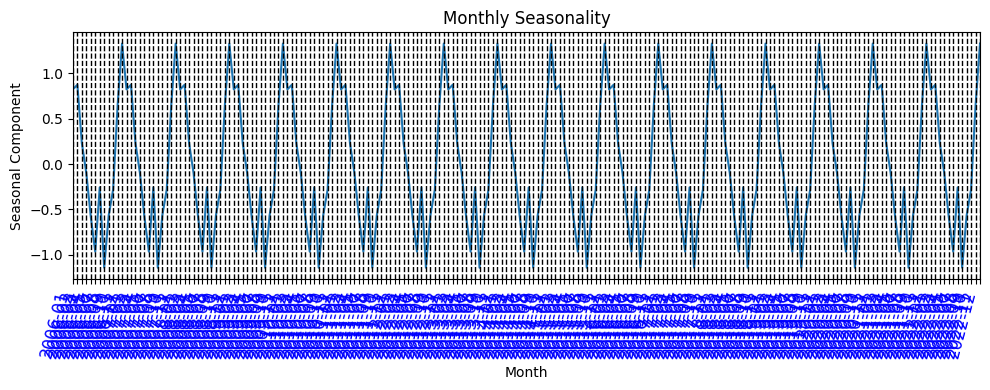

In [31]:
import statsmodels.api as sm

df_seasonality = df.copy()

# Set 'Date' column as the index of the DataFrame
df_seasonality.set_index('Date', inplace=True)

# Resample the data to monthly frequency
monthly_data = df_seasonality['Close'].resample('M').mean()

# Get the month numbers for the xticks
month_numbers = pd.to_datetime(monthly_data.index).strftime('%m')

df_monthly_data= monthly_data.to_frame(name="Close")
df_monthly_data['month_numbers'] = month_numbers

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(monthly_data, model='additive')

# Plot the seasonal component
fig, ax = plt.subplots()

decomposition.seasonal.plot(ax=ax)

times = np.arange('2006-01', '2023-01', dtype='datetime64[M]')
ax.set_xticks(times)
# ax.set_xticklabels(times )

for i in np.arange(0, len(df), 1):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)

plt.title('Monthly Seasonality' ,  fontsize = 12)
plt.xlabel('Month',  fontsize = 10)
plt.ylabel('Seasonal Component',fontsize = 10)

plt.rcParams['figure.figsize'] = (30, 10)

fig.autofmt_xdate()
ax.set_xticklabels(times,rotation = 75,
                   ha = 'right', fontsize = 12,
                   color = 'blue')

plt.tight_layout()
plt.show()

Figure: We can see recurring patterns that indicate monthly seasonality in our stock market data. The dashed vertical lines separate periods of One month per year.

By looking at the total monthly Close Price, it is easy to identify a repeating pattern every month, with a high rise of Close price being recorded during July & November of each year, and a drop in June & September of each year.

This observation is usually enough to determine that the dataset is seasonal, and it suggests that there is a monthly pattern or seasonality in the data.

According to tradethatswing.) , those are the Best and Worst Months for the Stock Market – Seasonal Pattern.

In [37]:
from IPython.display import Image
from google.colab import files
uploaded=files.upload()

Saving Screenshot (326).png to Screenshot (326) (1).png


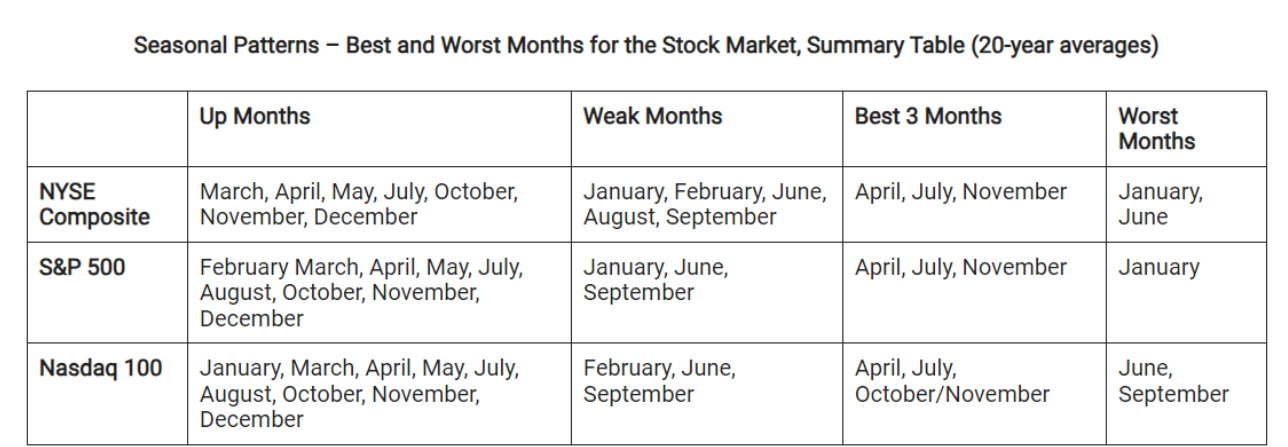

In [38]:
Image('Screenshot (326) (1).png')

In [39]:
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close,Month,Year
0,2006-03-01,36.849998,37.200001,1013200,38.279999,37.450001,35.305672,3,2006
1,2006-04-01,37.700001,37.700001,1928400,40.599998,39.200001,36.955467,4,2006
2,2006-05-01,38.910000,39.180000,317900,39.709999,39.709999,37.436268,5,2006
3,2006-06-01,38.139999,39.709999,349200,39.709999,39.000000,36.766914,6,2006
4,2006-09-01,38.500000,38.799999,220800,38.880001,38.610001,36.399242,9,2006


Now we reach the interesting problem of encoding Date as a usable feature for our models. Right now, the date_time feature can not be usable by our models, since it is a datetime string,it's needed to convert it into a numerical value.

A simple way to do that is to express the date as Month and Year. This is achieved at the previous section. thus we do not need Date feature anymore.

In [40]:
# 'Month','Year',
cols_to_drop = ['Date']
df = df.drop(cols_to_drop, axis=1)

df.head()

,Low,Open,Volume,High,Close,Adjusted Close,Month,Year
0,36.849998,37.200001,1013200,38.279999,37.450001,35.305672,3,2006
1,37.700001,37.700001,1928400,40.599998,39.200001,36.955467,4,2006
2,38.910000,39.180000,317900,39.709999,39.709999,37.436268,5,2006
3,38.139999,39.709999,349200,39.709999,39.000000,36.766914,6,2006
4,38.500000,38.799999,220800,38.880001,38.610001,36.399242,9,2006


Our feature engineering is complete, and the data is ready to be scaled and split into training, validation, and test sets.


#### 3. Splitting and scaling the data
The final step is to split the dataset into training, validation, and test sets, and to scale the data.

Note that we’ll first split the data, so that we scale it using only the information from the training set, thus avoiding information leakage. Scaling the data will decrease training time and improve the performance of our models.

We’ll split the data 70:20:10 for the training, validation, and test sets respectively.

In [41]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [42]:
#Next, we’ll fit the scaler to the training set only, and scale each individual set.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

Save Data

We can save each set to be used later for modeling.

In [43]:
train_df.to_csv('../train.csv', index=False, header=True)
val_df.to_csv('../val.csv', index=False, header=True)
test_df.to_csv('../test.csv', index=False, header=True)

In [ ]:
#We are now ready to move on to the modeling step.

#### Preparing for modeling with deep learning:
Recall that the objective of this project is to predict Close price in the next month (21 working days). This means that we must build a univariate multi-step model, since we are forecasting only one target + 21 timesteps into the future.

We will build:

- Two baselines,
- A linear model,
- A deep neural network model,
- A longshort-term memory (LSTM) model,
- A convolutional neural network (CNN),
- A combination of CNN and LSTM, and
- An autoregressive LSTM.

In the end, we will use the mean absolute error (MAE) to determine which model is the best. The one that achieves the lowest MAE on the test set will be the top-performing model.

Let's read the training set, validation set, and test set so they are ready for modeling. 🚀

In [44]:
train_df = pd.read_csv('../train.csv')
val_df = pd.read_csv('../val.csv')
test_df = pd.read_csv('../test.csv')

we’ll build a dictionary to store the column names and their corresponding indexes. This will be useful later on for building the baseline models and creating windows of data.

In [45]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

#### Defining the DataWindow class
DataWindow class allows us to quickly create windows of data for training deep learning models. Each window of data contains a set of inputs and a set of labels. The model is then trained to produce predictions as close as possible to the labels using the inputs.

The class is based on:

- 1.**The width** of the input is simply the number of timesteps that are fed into the model.
- 2.**The width of label** is equivalent to the number of timesteps in the predictions.
- 3.**The shift** is the number of timesteps separating the input and the predictions. If we predict the next timestep, the shift is 1. If we predict the next 21 days, the shift is 21.
Then, we’ll define a function to plot:

- The input data,
- The predictions, and
- The actual values

Since we will be working with many time windows, we’ll show only the plot of three time windows

In [46]:
class DataWindow():

  def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

            self.train_df = train_df
            self.val_df = val_df
            self.test_df = test_df

            #Name of the column that we wish to predict
            self.label_columns = label_columns
            if label_columns is not None:
                #Create a dictionary with the name and index of the label column. This will be used for plotting.
                self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            #Create a dictionary with the name and index of each column. This will be used to separate the features from the target variable
            self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

            self.input_width = input_width
            self.label_width = label_width
            self.shift = shift

            self.total_window_size = input_width + shift

            #The slice function returns a slice object that specifies how to slice a sequence.
            # In this case, it says that the input slice starts at 0 and ends when we reach the input_width.
            self.input_slice = slice(0, input_width)
            #Assign indices to the inputs. These are useful for plotting.
            self.input_indices = np.arange(self.total_window_size)[self.input_slice]


            #Get the index at which the label starts. In this case, it is the total window size minus the width of the label.
            self.label_start = self.total_window_size - self.label_width
            #The same steps that were applied for the inputs are applied for labels.
            self.labels_slice = slice(self.label_start, None)
            self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_to_inputs_labels(self, features):
            #Slice the window to get the inputs using the input_slice defined in __init__.
            inputs = features[:, self.input_slice, :]
            #Slice the window to get the labels using the labels_slice defined in __init__
            labels = features[:, self.labels_slice, :]

            #If we have more than one target, we stack the labels.
            if self.label_columns is not None:
                labels = tf.stack(
                    [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                    axis=-1
                )
            #The shape will be [batch, time, features].
            # At this point,we only specify the time dimension and allow the batch and feature dimensions to be defined later.
            inputs.set_shape([None, self.input_width, None])
            labels.set_shape([None, self.label_width, None])

            return inputs, labels

  def plot(self, model=None, plot_col='Close', max_subplots=3):
            inputs, labels = self.sample_batch

            plt.figure(figsize=(12, 8))
            plot_col_index = self.column_indices[plot_col]
            max_n = min(max_subplots, len(inputs))

            #Plot the inputs. They will  appear as a continuous blue line with dots.
            for n in range(max_n):
                plt.subplot(3, 1, n+1)
                plt.ylabel(f'{plot_col} [scaled]')
                plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                        label='Inputs', marker='.', zorder=-10)

                if self.label_columns:
                  label_col_index = self.label_columns_indices.get(plot_col, None)
                else:
                  label_col_index = plot_col_index

                if label_col_index is None:
                  continue

                #Plot the labels or actual. They will appear as green squares.
                plt.scatter(self.label_indices, labels[n, :, label_col_index],
                            edgecolors='k', marker='s', label='Labels', c='green', s=64)
                if model is not None:
                  predictions = model(inputs)
                  #Plot the predictions. They will appear as red crosses.
                  plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions',
                              c='red', s=64)

                if n == 0:
                  plt.legend()

            plt.xlabel('Date (Day)')
            plt.ylabel('Closing price (USD)')

  def make_dataset(self, data):
            data = np.array(data, dtype=np.float32)
            ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                #Pass in the data. This corresponds to our training set, validation set, or test set.
                data=data,
                #Targets are set to None, as they are handled by the split_to_input_labels function.
                targets=None,
                #Define the total length of s the array, which is equal to the total window length.
                sequence_length=self.total_window_size,
                #Define the number of timesteps separating each sequence. In our case, we want the sequences to be consecutive, so sequence_stride=1.
                sequence_stride=1,
                #Shuffle the sequences. Keep in mind that the data is still in chronological order. We are simply shuffling the order of the sequences, which makes the model more robus
                shuffle=True,
                #Define the number of sequences in a single batch
                batch_size=32
            )

            ds = ds.map(self.split_to_inputs_labels)
            return ds

  @property
  def train(self):
      return self.make_dataset(self.train_df)

  @property
  def val(self):
      return self.make_dataset(self.val_df)

  @property
  def test(self):
      return self.make_dataset(self.test_df)

  @property
  def sample_batch(self):
    #Get a sample batch of data for plotting purposes. If the sample batch does not exist, we’ll retrieve a sample batch and cache it
      result = getattr(self, '_sample_batch', None)
      if result is None:
          result = next(iter(self.train))
          self._sample_batch = result
      return result

With the DataWindow class defined, we only need a function to compile and train the different models we’ll develop.

## Utility function to train our models

Our final step before launching our experiments is to build a function that automates the training process. This is the **compile_and_fit** function.

Recall that this function takes in a model and a window of data. Then it implements **early stopping**, meaning that the model will stop training if the validation loss does not change for three consecutive epochs. This is also the function in which we specify the loss function to be the MSE and the evaluation metric to be the MAE.

In [47]:
#The function takes a model, and a window of data from the DataWindow class.
# The patience: is the number of epochs after which the model should stop training if the validation loss does not improve;
# max_epochs: sets a maximum number of epochs to train the model.
def compile_and_fit(model, window, patience=3, max_epochs=50):

    #Early stopping occurs if 3 consecutive epochs do not decrease the validation loss, as set by the patience parameter
    # The validation loss is tracked to determine if we should apply early stopping or not.
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    # The MSE is used as the loss function.
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()]) #the MAE as an evaluation metric to compare the performance of our models

    # The model is fit on the training set.
    history = model.fit(window.train,
                       epochs=max_epochs,   #The model can train for at most 50 epochs, as set by the max_epochs parameter.
                       validation_data=window.val,
                       callbacks=[early_stopping]) #early_stopping is passed as a callback. If the validation loss does not decrease after 3 consecutive epochs, the model stops training. This avoids overfitting.

    return history

**At this point, we have everything we need to start developing models to forecast the next 21 days of Close price.**

Modeling with Deep Learning
We will implement:

- Two baseline model.
- A linear model.
- A deep neural network.
- A long short-term memory (LSTM) model.
- A convolutional neural network (CNN)
- A combination of CNN and LSTM
- An autoregressive LSTM.

# First: Baseline models
Every forecasting project must start with a baseline model. Baselines serve as a benchmark for our more sophisticated models, as they can only be better in comparison to a certain benchmark.we’ll build two baseline models:

a. One that repeats the last known value (last day) and,

b. Another that repeats the last month (21 days) of data.

We’ll start by creating the window of data that will be used. Recall that the objective is to forecast the next 21 working days of Close price, Thus:

- the length of our `label sequence` is 21 timesteps,
- the `shift` will also be 21 timesteps, and
- We’ll also use an `input length` of 21.

In [48]:
multi_window = DataWindow(input_width=21, label_width=21, shift=21,label_columns=['Close'])

## a. Repeat last value - Baseline
To predict the last known value, We implement **MultiStepLastBaseline class** that simply takes in the input and repeats the last value of the input sequence over 21 timesteps. This acts as the prediction of the model.

In [49]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 21, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 21, 1])

We can now generate predictions using this baseline and store its performance in a dictionary. This dictionary will store the performance of each model so that we can compare them at the end

Note that we will not display the MAE of each model as we build them. We will compare the evaluation metrics once all the models are trained.

In [50]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

26/26 [==============================] - 1s 26ms/step - loss: 0.1985 - mean_absolute_error: 0.2880


Let's visualize the predictions using the plot method of the DataWindow class. It will display three plots in the figure, as specified in the DataWindow class.

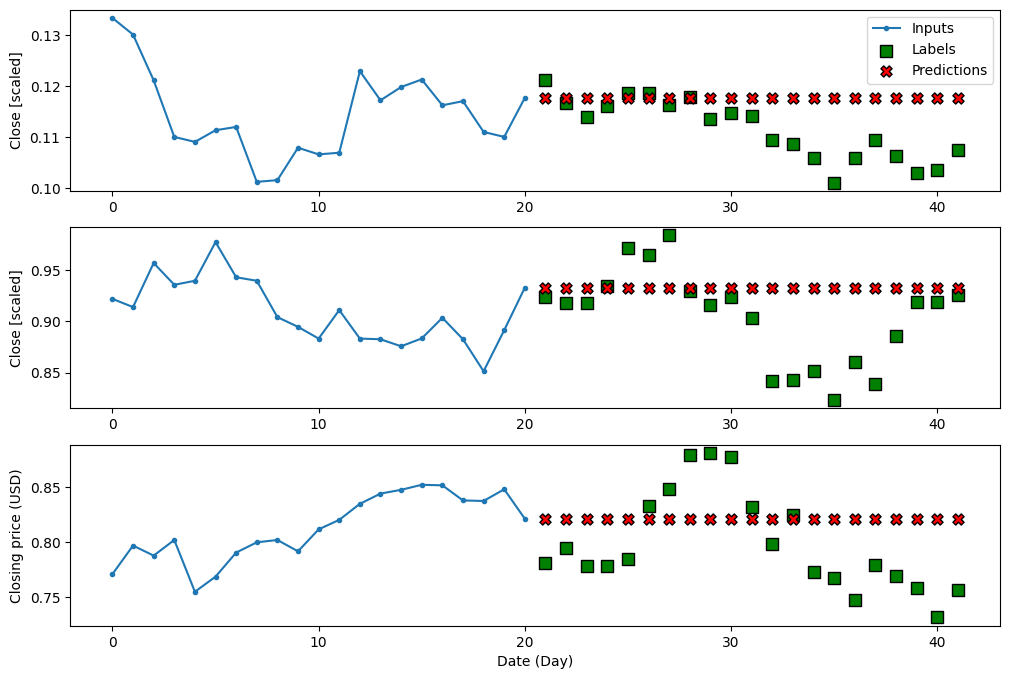

In [51]:
multi_window.plot(baseline_last)


Figure: Predictions from the baseline model, which simply repeats the last known input value (last day) , The inputs are shown with square markers, and the labels are shown with crosses. Each data window consists of 21 timesteps with square markers followed by 21 labels with crosses.

### b. Repeat last day - Baseline

Next, let’s implement a baseline model that repeats the input sequence (21 day),This means that the prediction for the next 21 days will simply be the last known 21 days of data as it is.

In [52]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

we can generate predictions and store the baseline’s performance for comparison.

In [53]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Close'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

26/26 [==============================] - 1s 6ms/step - loss: 0.1976 - mean_absolute_error: 0.2941


Let's visualize the generated predictions

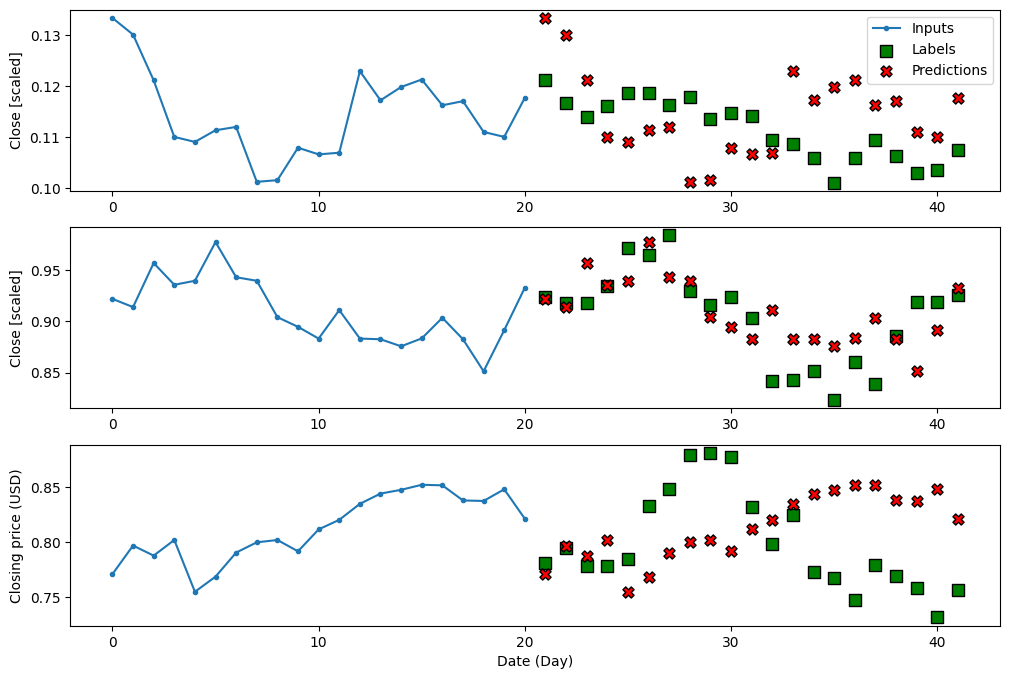

In [54]:
multi_window.plot(baseline_repeat)

Figure:We can see that the predictions are equal to the input sequence, which is the expected behavior for this baseline model.

**With the baseline models in place, we can move on to the slightly more complex linear model.**

# Second: Linear model
One of the simplest models we can build is a linear model.A linear model simply takes all the features, calculates a weight for each of them, and sums them to output a prediction for the next timestep. This model consists of only an input layer and an output layer. Thus, only a sequence of weights is computed to generate predictions that are as close as possible to the labels. In this case, we’ll build a model with :

- One Dense output layer that has only one neuron, since we are predicting only one target.

We’ll then train the model and store its performance.

In [55]:
label_index = column_indices['Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

In [56]:
history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 [==============================] - 1s 6ms/step - loss: 0.1100 - mean_absolute_error: 0.2475 - val_loss: 0.0269 - val_mean_absolute_error: 0.1384
Epoch 2/50
93/93 [==============================] - 0s 5ms/step - loss: 0.0238 - mean_absolute_error: 0.1308 - val_loss: 0.0204 - val_mean_absolute_error: 0.1135
Epoch 3/50
93/93 [==============================] - 0s 4ms/step - loss: 0.0139 - mean_absolute_error: 0.1021 - val_loss: 0.0173 - val_mean_absolute_error: 0.1054
Epoch 4/50
93/93 [==============================] - 0s 5ms/step - loss: 0.0097 - mean_absolute_error: 0.0846 - val_loss: 0.0133 - val_mean_absolute_error: 0.0932
Epoch 5/50
93/93 [==============================] - 0s 5ms/step - loss: 0.0070 - mean_absolute_error: 0.0702 - val_loss: 0.0102 - val_mean_absolute_error: 0.0815
Epoch 6/50
93/93 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_error: 0.0593 - val_loss: 0.0084 - val_mean_absolute_error: 0.0729
Epoch 7/50
93/93 [==========

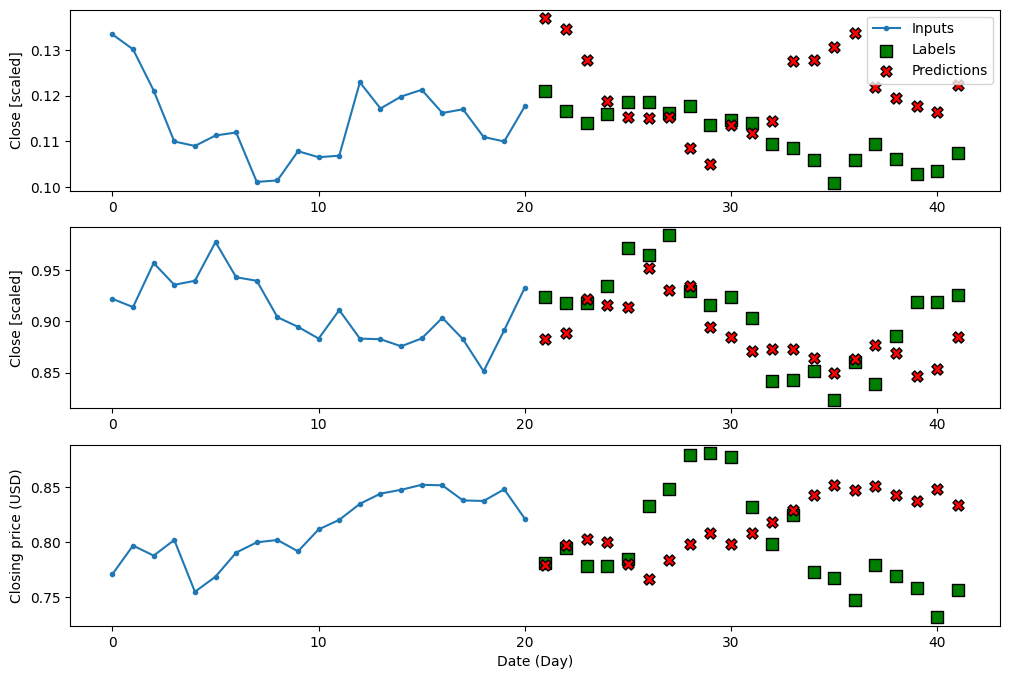

In [57]:
multi_window.plot(linear)

Figure: Predictions generated from a linear model

**Now let’s add hidden layers and implement a deep neural network.**

# Third: Deep neural network - Dense Model
The previous linear model did not have any hidden layers; it was simply an input layer and an output layer. Now we’ll add hidden layers, which will help us model nonlinear relationships in the data.

Here we’ll stack:

- Two Dense layers with 64 neurons and,
- Use ReLU as the activation function.

Then we’ll train the model and store its performance for comparison.

In [58]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 [==============================] - 2s 8ms/step - loss: 0.0480 - mean_absolute_error: 0.1360 - val_loss: 0.0057 - val_mean_absolute_error: 0.0573
Epoch 2/50
93/93 [==============================] - 1s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0429 - val_loss: 0.0055 - val_mean_absolute_error: 0.0568
Epoch 3/50
93/93 [==============================] - 1s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0413 - val_loss: 0.0080 - val_mean_absolute_error: 0.0706
Epoch 4/50
93/93 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_absolute_error: 0.0413 - val_loss: 0.0064 - val_mean_absolute_error: 0.0630
Epoch 5/50
26/26 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_absolute_error: 0.0674


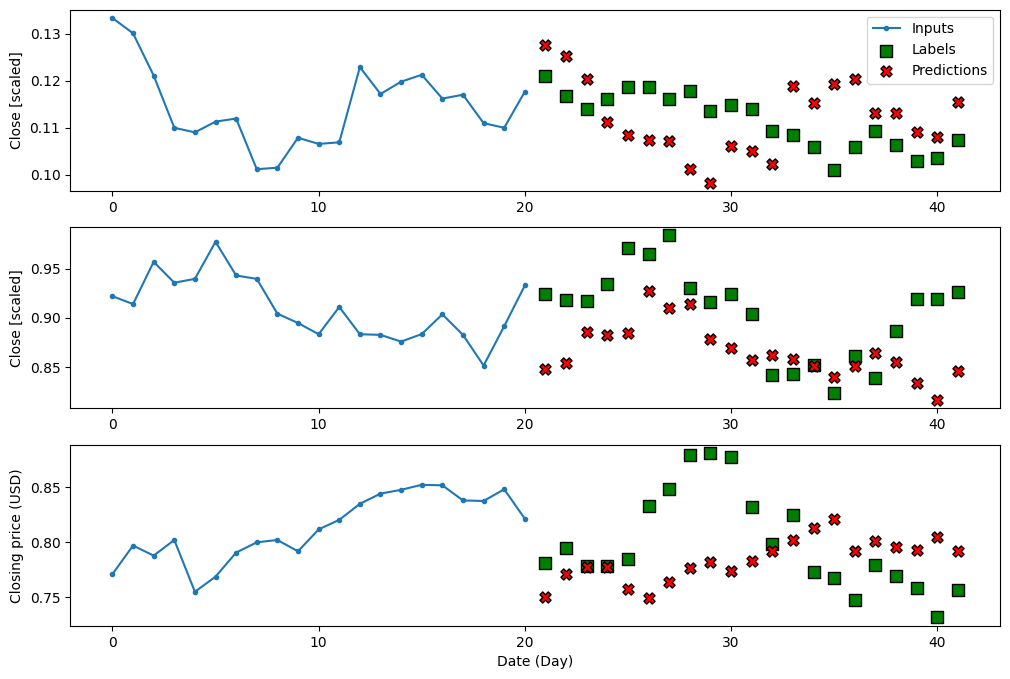

In [59]:
multi_window.plot(dense)

Figure:Predections genertaed from Dense Model

**Now let’s try LSTM ! **

# Fourth: Long short-term memory (LSTM) model 🍍
Long short-term memory (LSTM) is a deep learning architecture that is a subtype of RNN. LSTM addresses the problem of short-term memory by adding the cell state. This allows for past information to flow through the network for a longer period of time, meaning that the network still carries information from early values in the sequence.

The main advantage of the long short-term memory (LSTM) model is that **it keeps information from the past in memory**. This makes it especially suitable for treating sequences of data, like time series. It allows us to combine information from the present and the past to produce a prediction.

- We’ll feed the input sequence through an LSTM layer before sending it to the output layer, which remains a Dense layer with one neuron.
We’ll then train the model and store its performance in the dictionary for comparison at the end.

In [60]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 [==============================] - 5s 24ms/step - loss: 0.0642 - mean_absolute_error: 0.1674 - val_loss: 0.0144 - val_mean_absolute_error: 0.0816
Epoch 2/50
93/93 [==============================] - 3s 32ms/step - loss: 0.0101 - mean_absolute_error: 0.0630 - val_loss: 0.0120 - val_mean_absolute_error: 0.0814
Epoch 3/50
93/93 [==============================] - 1s 15ms/step - loss: 0.0069 - mean_absolute_error: 0.0547 - val_loss: 0.0107 - val_mean_absolute_error: 0.0793
Epoch 4/50
93/93 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_absolute_error: 0.0512 - val_loss: 0.0082 - val_mean_absolute_error: 0.0683
Epoch 5/50
93/93 [==============================] - 2s 19ms/step - loss: 0.0047 - mean_absolute_error: 0.0480 - val_loss: 0.0077 - val_mean_absolute_error: 0.0673
Epoch 6/50
93/93 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_absolute_error: 0.0460 - val_loss: 0.0093 - val_mean_absolute_error: 0.0768
Epoch 7/50
93/93 [====

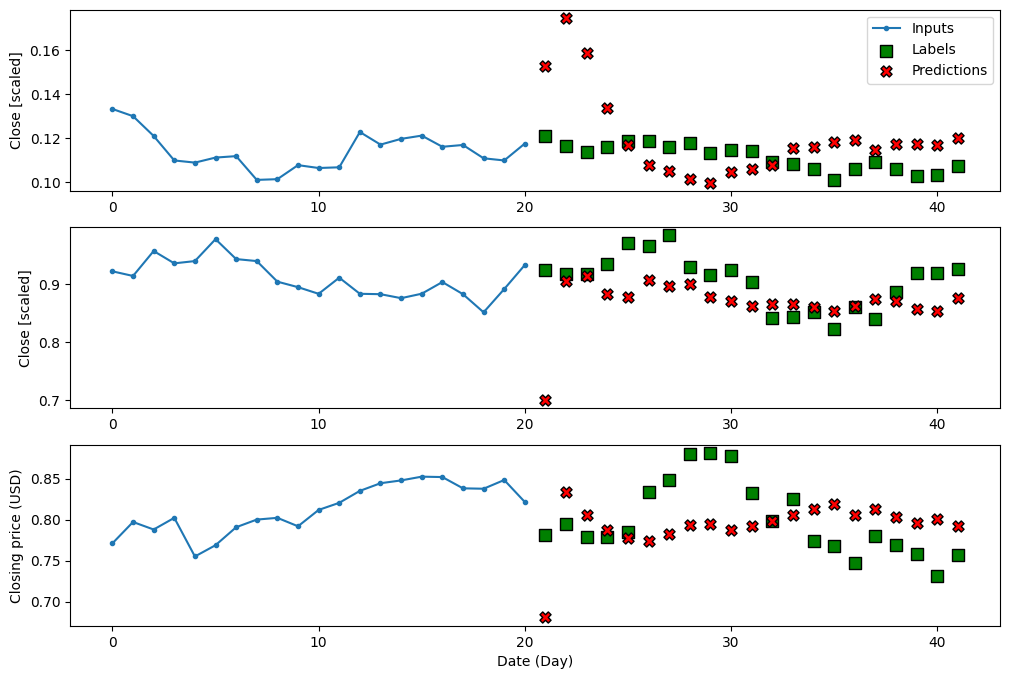

In [61]:
multi_window.plot(lstm_model)

Figure: Predictions generated from the LSTM model.

**Now let’s try CNN !**

# Fifth: Convolutional neural network (CNN)
## Convolutional neural network (CNN)

- A convolutional neural network (CNN) is a deep learning architecture that uses the convolution operation. This allows the network to reduce the feature space, effectively filtering the inputs and preventing overfitting.
- The convolution is performed with a kernel, which is also trained during model fitting. The stride of the kernel determines the number of steps it shifts at each step of the convolution. In time series forecasting, only 1D convolution is used.
- To avoid reducing the feature space too quickly, we can use padding, which adds zeros before and after the input vector. This keeps the output dimension the same as the original feature vector, allowing us to stack more convolution layers, which in turn allows the network to process the features for a longer time.
AThe main advantage of convolutional neural network (CNN) is that it uses the convolution function to reduce the feature space. This effectively filters our time series and performs feature selection. Furthermore, a **CNN is faster to train than an LSTM** since the operations are parallelized, whereas the LSTM must treat one element of the sequence at a time.

Because the convolution operation reduces the feature space, we must provide a slightly longer input sequence to make sure that the output sequence contains 21 timesteps. How much longer it needs to be depends on the length of the kernel that performs the convolution operation. In this case, we’ll use a **kernel length of 3.**

This is an arbitrary choice, Given that we need 21 labels, we can calculate the input sequence using equation:

**input length = label length + kernel length – 1**

This forces us to define a window of data specifically for the CNN model. Note that since we are defining a new window of data, the sample batch used for plotting will differ from the one used so far.



In [62]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 21
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

In [63]:
cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=21, label_columns=['Close'])

Next, we’ll:

- send the input through a **Conv1D layer**, which filters the input sequence.
- Then it is fed to a **Dense layer with 32 neurons** for learning before going to the output layer.

As always, we’ll train the model and store its performance for comparison.

In [64]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
92/92 [==============================] - 2s 7ms/step - loss: 0.0554 - mean_absolute_error: 0.1524 - val_loss: 0.0061 - val_mean_absolute_error: 0.0594
Epoch 2/50
92/92 [==============================] - 1s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0437 - val_loss: 0.0052 - val_mean_absolute_error: 0.0537
Epoch 3/50
92/92 [==============================] - 1s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0425 - val_loss: 0.0064 - val_mean_absolute_error: 0.0621
Epoch 4/50
92/92 [==============================] - 1s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0421 - val_loss: 0.0060 - val_mean_absolute_error: 0.0609
Epoch 5/50
26/26 [==============================] - 0s 3ms/step - loss: 0.0074 - mean_absolute_error: 0.0678


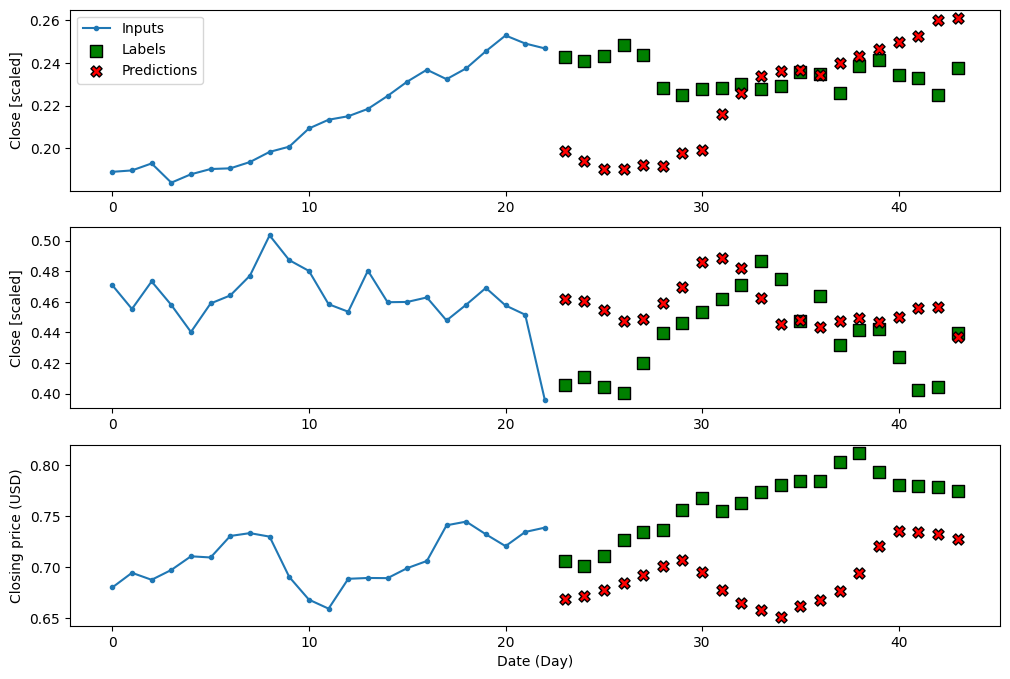

In [65]:
cnn_multi_window.plot(cnn_model)

Figure:shows that the input sequence differs from our previous methods because working with a CNN involves windowing the data again to account for the convolution kernel length. The training, validation, and test sets remain unchanged, so it is still valid to compare all the models’ performance.

Now let’s combine the CNN model with the LSTM model.

#Sixth: Combining a CNN with an LSTM
We know that:

- LSTM is good at treating sequences of data,
- While CNN can filter a sequence of data.
Therefore, it is a reasonable hypothesis that filtering our input sequence before feeding it to an LSTM might improve the performance, It is interesting to test whether combining CNN with LSTM can result in a better-performing model.

We’ll:

- Feed the input sequence to a Conv1D layer,but
- Use an LSTM layer for learning this time.

Then we’ll send the information to the output layer. Again, we’ll train the model and store its performance.

In [66]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

In [67]:
history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
92/92 [==============================] - 5s 21ms/step - loss: 0.0540 - mean_absolute_error: 0.1493 - val_loss: 0.0104 - val_mean_absolute_error: 0.0740
Epoch 2/50
92/92 [==============================] - 1s 15ms/step - loss: 0.0059 - mean_absolute_error: 0.0534 - val_loss: 0.0070 - val_mean_absolute_error: 0.0624
Epoch 3/50
92/92 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_absolute_error: 0.0472 - val_loss: 0.0077 - val_mean_absolute_error: 0.0678
Epoch 4/50
92/92 [==============================] - 2s 16ms/step - loss: 0.0036 - mean_absolute_error: 0.0440 - val_loss: 0.0062 - val_mean_absolute_error: 0.0602
Epoch 5/50
92/92 [==============================] - 2s 17ms/step - loss: 0.0034 - mean_absolute_error: 0.0428 - val_loss: 0.0084 - val_mean_absolute_error: 0.0721
Epoch 6/50
92/92 [==============================] - 2s 19ms/step - loss: 0.0034 - mean_absolute_error: 0.0424 - val_loss: 0.0081 - val_mean_absolute_error: 0.0704
Epoch 7/50
26/26 [====

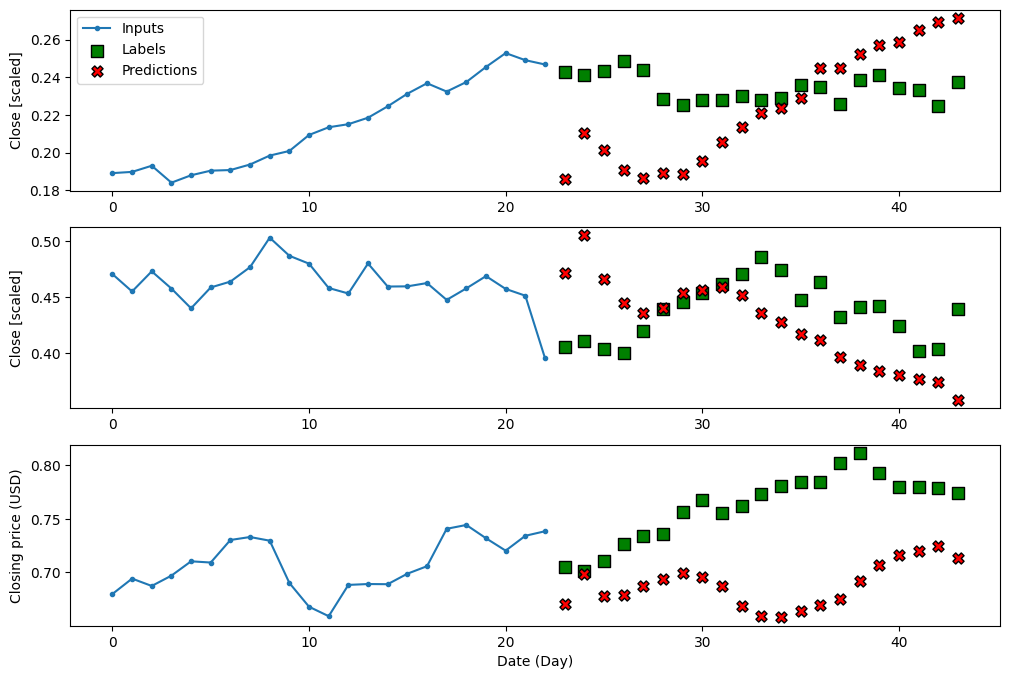

In [68]:
cnn_multi_window.plot(cnn_lstm_model)

Figure: Predictions from a CNN combined with an LSTM model

**Now let’s try the AR-LSTM model.**

# Seventh: The Autoregressive LSTM model - Using Predictions To Make More Predictions
The final model that we’ll implement is an autoregressive LSTM (ARLSTM) model. **Instead of generating the entire output sequence in a single shot, the Autoregressive model will generate one prediction at a time and use that prediction as an input to generate the next one**.

This kind of architecture is present in state-of-the-art forecasting models, but it is worth nothing that Autoregressive deep learning models come with a **major caveat**, which is **the accumulation of error**. If the model generates a very bad first prediction, this mistake will be carried on to the next predictions, which will magnify the errors. That error accumulates as it is fed back into the model, meaning that later predictions will have a larger error than earlier predictions. Nevertheless, it is worth testing this model and have this model in our toolbox of time series forecasting methods.

Let's see if it works well in our situation.

The first step is defining the class that implements the ARLSTM model.

In [69]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)

        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [70]:
#We can then use this class to initialize our model. We’ll train the model on the multiwindow and store its performance for comparison.

In [77]:
AR_LSTM = AutoRegressive(units=32, out_steps=21)
history = compile_and_fit(AR_LSTM, multi_window)

val_performance['ARLSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['ARLSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 [==============================] - 7s 25ms/step - loss: 0.0374 - mean_absolute_error: 0.1183 - val_loss: 0.0072 - val_mean_absolute_error: 0.0688
Epoch 2/50
93/93 [==============================] - 2s 17ms/step - loss: 0.0029 - mean_absolute_error: 0.0400 - val_loss: 0.0044 - val_mean_absolute_error: 0.0514
Epoch 3/50
93/93 [==============================] - 2s 17ms/step - loss: 0.0026 - mean_absolute_error: 0.0368 - val_loss: 0.0060 - val_mean_absolute_error: 0.0590
Epoch 4/50
93/93 [==============================] - 3s 26ms/step - loss: 0.0023 - mean_absolute_error: 0.0347 - val_loss: 0.0042 - val_mean_absolute_error: 0.0491
Epoch 5/50
93/93 [==============================] - 2s 18ms/step - loss: 0.0026 - mean_absolute_error: 0.0363 - val_loss: 0.0055 - val_mean_absolute_error: 0.0571
Epoch 6/50
93/93 [==============================] - 2s 18ms/step - loss: 0.0022 - mean_absolute_error: 0.0337 - val_loss: 0.0043 - val_mean_absolute_error: 0.0509
Epoch 7/50
26/26 [====

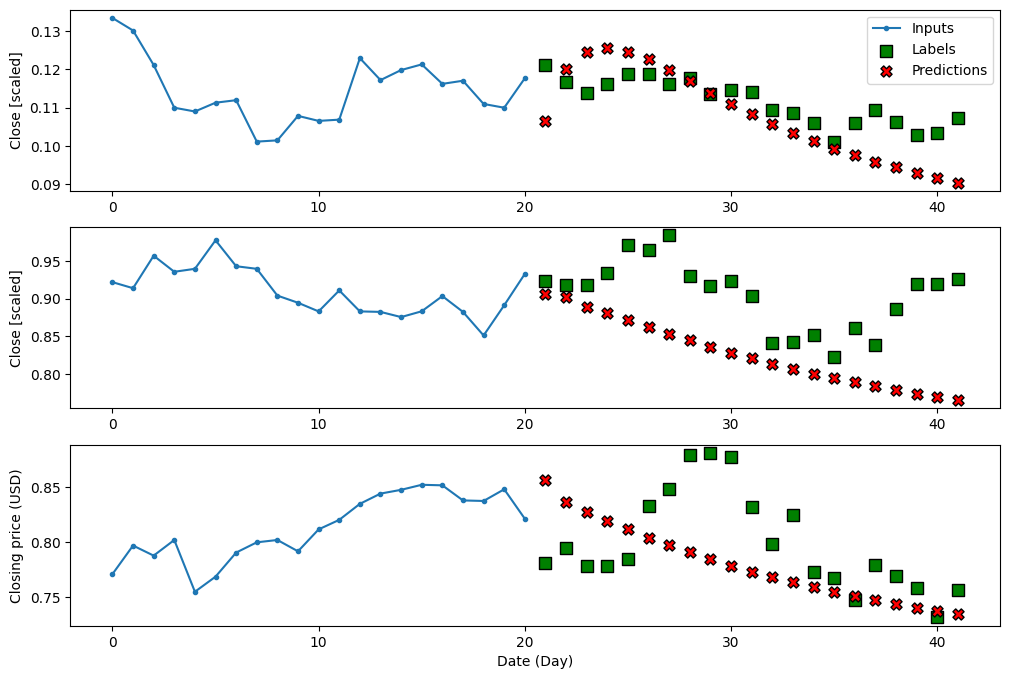

In [74]:
multi_window.plot(AR_LSTM)

Figure:Predictions from the ARLSTM model

# Selecting Best Model
We have built many models for this project, from a linear model to an ARLSTM model. Now let’s visualize the MAE of each model to determine the champion. We’ll plot the MAE on both the validation and test sets. The result is shown below.

In [78]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

<Figure size 1000x600 with 0 Axes>

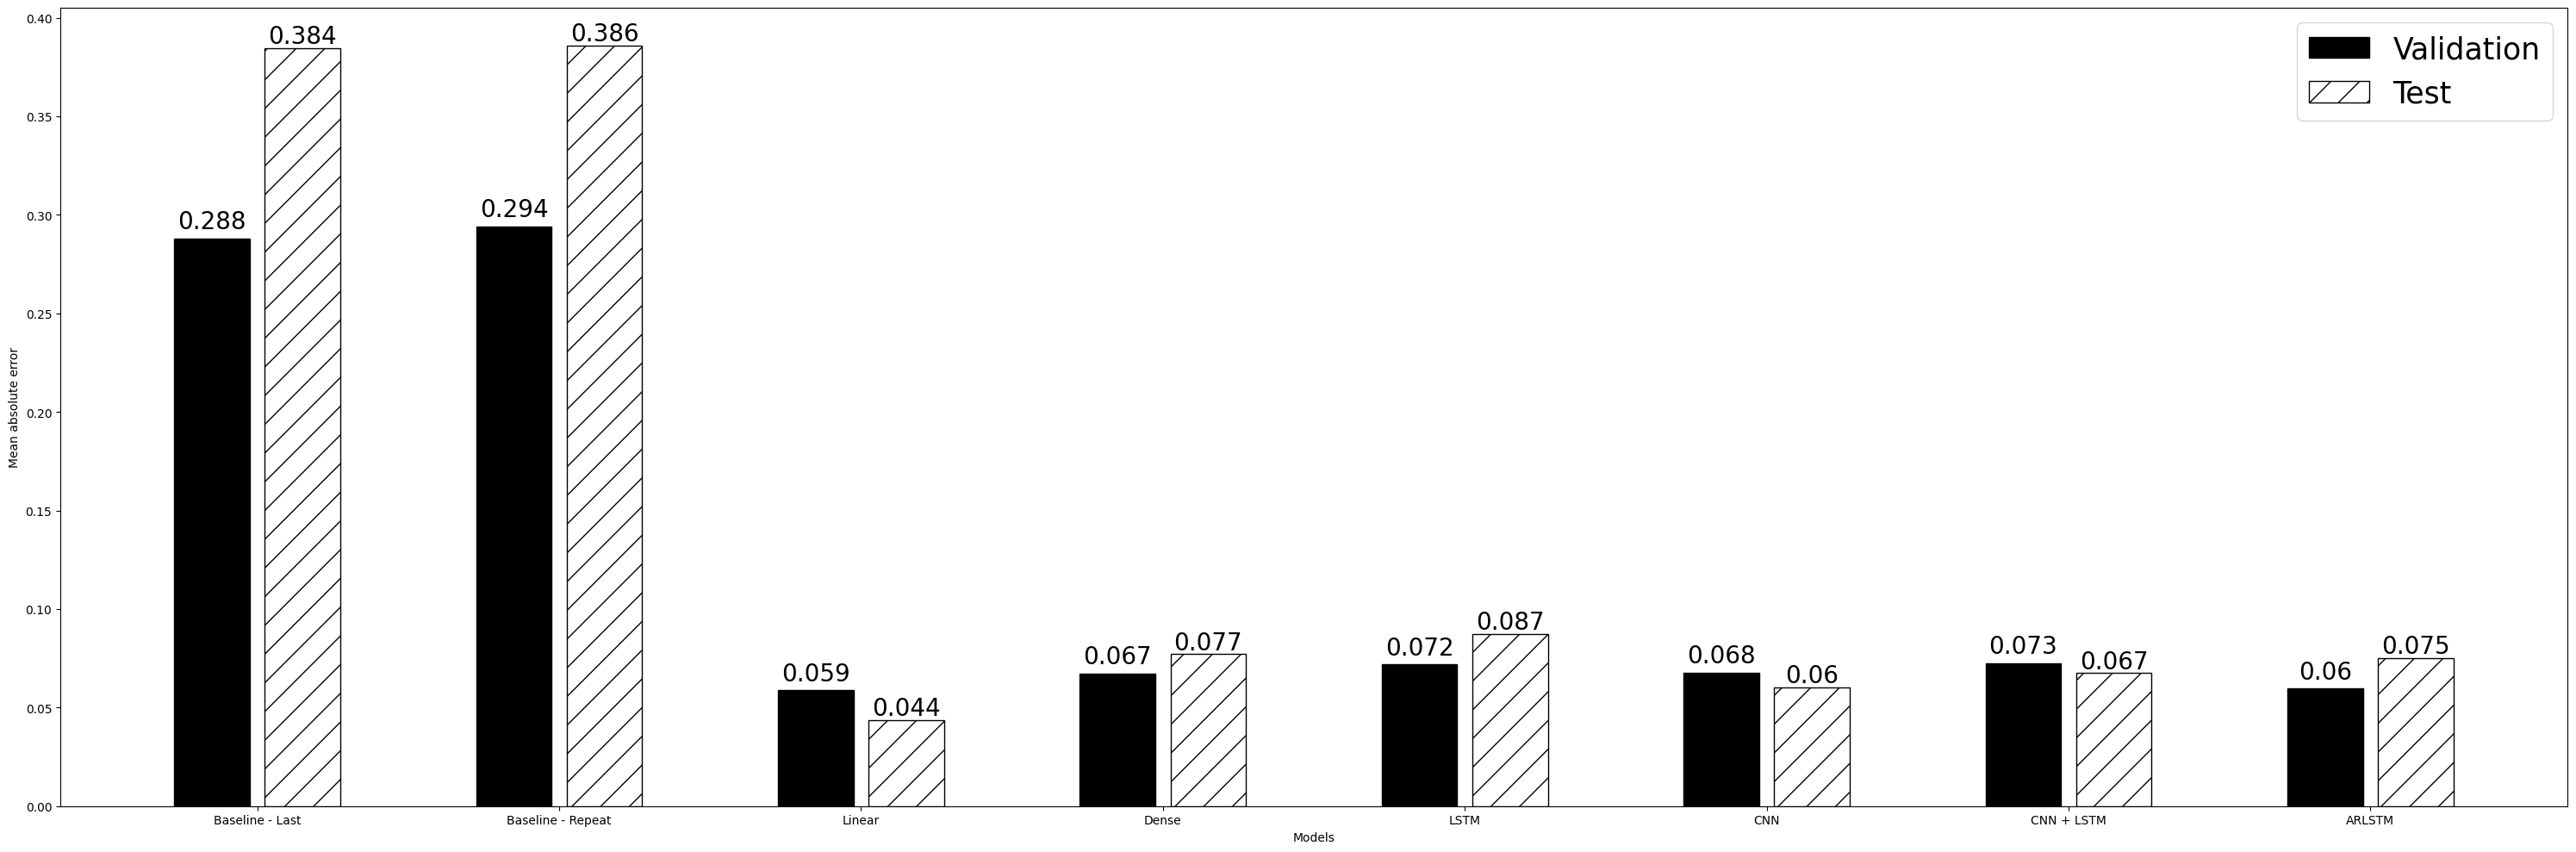

<Figure size 1000x600 with 0 Axes>

In [79]:
x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')


font_prop = font_manager.FontProperties( size=20)

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center',fontproperties=font_prop)

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center',fontproperties=font_prop)

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')

plt.legend(fontsize=25) # using a size in points

plt.tight_layout()
plt.figure(figsize=(10,6))

Figure:Comparing the MAE of all models tested.

In [80]:
model_names = ['Baseline-Last', 'Baseline-Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'LSTM+CNN', 'ARLSTM']
data = {'Test - MAE': mae_test, 'Validation - MAE': mae_val}
df = pd.DataFrame(data, index=model_names)
df_sorted = df.sort_values(by='Test - MAE', ascending=True)
df_sorted.T

,Linear,CNN,LSTM+CNN,ARLSTM,Dense,LSTM,Baseline-Last,Baseline-Repeat
Test - MAE,0.043786,0.060217,0.067443,0.075251,0.077024,0.087417,0.384453,0.385752
Validation - MAE,0.058768,0.067829,0.072604,0.059708,0.067397,0.071904,0.287968,0.294060


The results indicates that:

All the models performed much better than the baselines.
Furthermore, our champion is the LINEAR, since it achieved a MAE of 0.043 on the test set, which is the lowest MAE of all, second best performer is CNN with MAE of 0.060, thus, it's recommended using LINEAR models to forecast the Close price over the next month.
Takeaways

We always need to keep in mind that the performance of each model depends on the problem at stake. The takeaway here is not that the LINEAR is always the best model, but that it is the best-performing model for this situation. For another dataset, we might find another champion model.

[A special thanks to HAGAR BENDARY for his guided noteboook in Kaggle]
